In [1]:
# imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os


from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

from sklearn.model_selection import train_test_split

# For reproducibility
np.random.seed(42)

In [3]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [4]:
#pip install seaborn

#### Read in relevant csv file with information about our data 

Read in a csv file with file path and camera trap site

In [5]:
train_features = pd.read_csv('./data/train_features.csv')

In [6]:
train_features.head()

,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036


Read in csv file with train labels 

In [7]:
train_labels = pd.read_csv('./data/train_labels.csv')

In [8]:
train_labels.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
train_labels_only = train_labels.drop(columns=['id'])

In [10]:
train_labels['label'] = train_labels_only.idxmax(axis=1)

In [11]:
train_labels.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,label
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,bird
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,monkey_prosimian
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,bird
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,monkey_prosimian
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,leopard


#### Merge the tables

I am merging the tables to add all relevant in one place. 

In [12]:
files_labels = pd.merge(train_features, train_labels, on='id')

In [13]:
files_labels.head()

,id,filepath,site,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,label
0,ZJ000000,train_features/ZJ000000.jpg,S0120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,bird
1,ZJ000001,train_features/ZJ000001.jpg,S0069,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,monkey_prosimian
2,ZJ000002,train_features/ZJ000002.jpg,S0009,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,bird
3,ZJ000003,train_features/ZJ000003.jpg,S0008,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,monkey_prosimian
4,ZJ000004,train_features/ZJ000004.jpg,S0036,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,leopard


### EDA

How many total observations are there in the training data?

In [14]:
files_labels.shape[0]

16488

In the training data, how many of each animal class do we have?

In [15]:
files_labels['label'].value_counts(normalize=True).round(2)

monkey_prosimian    0.15
antelope_duiker     0.15
civet_genet         0.15
leopard             0.14
blank               0.13
rodent              0.12
bird                0.10
hog                 0.06
Name: label, dtype: float64

In [122]:
class_count = files_labels.groupby('label').count()['id'].sort_values(ascending=False)
class_count

label
monkey_prosimian    2492
antelope_duiker     2474
civet_genet         2423
leopard             2254
blank               2213
rodent              2013
bird                1641
hog                  978
Name: id, dtype: int64

In [123]:
locations = [1, 2, 3, 4, 5, 6, 7, 8]
labels = [label.replace('_', '/').title() for label in class_count.index]

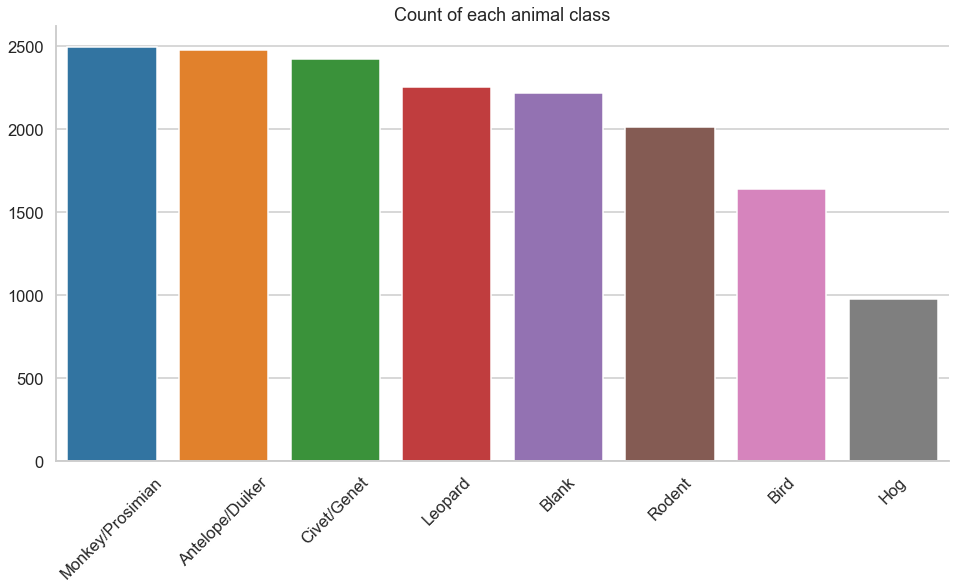

In [124]:
plt.figure(figsize=(16, 8))
sns.barplot(y=class_count, x=labels)
plt.title('Count of each animal class')
plt.xticks(rotation=45)
plt.ylabel('');
sns.despine(right=True)
plt.savefig('bar_animal_count', bbox_inches='tight')

In [19]:
#pd.set_option('display.max_rows', None)

#### Count of animal types by site

##### We can use groupby to check how many animal classes appear in each site and count how many observations of each class appears in each site

In [20]:
files_labels.groupby(['site', 'label']).count()['id'][:10]

site   label           
S0001  bird                11
       blank                6
       leopard             51
       monkey_prosimian    17
S0002  bird                 9
       blank               36
       monkey_prosimian    68
       rodent              58
S0003  antelope_duiker      6
       bird                 8
Name: id, dtype: int64

In [21]:
grouped = pd.DataFrame(data=files_labels.groupby(['site', 'label']).count()['id'])

Making a dataframe with the same information as above

In [22]:
grouped = grouped.rename(columns={'id': 'count'})

In [23]:
grouped.reset_index(inplace=True)
grouped.head()

,site,label,count
0,S0001,bird,11
1,S0001,blank,6
2,S0001,leopard,51
3,S0001,monkey_prosimian,17
4,S0002,bird,9


We have 148 total sites with trap cameras

In [24]:
grouped['site'].nunique()

148

#### Which sites has the highest observations of animals (regardless of class)?

In [25]:
grouped.groupby('site')['count'].sum().sort_values(ascending=False)[:10]

site
S0060    1132
S0009     664
S0063     557
S0008     541
S0036     456
S0043     444
S0059     438
S0038     429
S0120     423
S0062     380
Name: count, dtype: int64

#### Which sites have observations of all animal classes?

In [26]:
grouped['site'].value_counts().loc[grouped['site'].value_counts()==8]

S0170    8
S0036    8
Name: site, dtype: int64

In [27]:
grouped[(grouped['site']=='S0170')|(grouped['site']=='S0036')]

,site,label,count
148,S0036,antelope_duiker,45
149,S0036,bird,6
150,S0036,blank,35
151,S0036,civet_genet,14
152,S0036,hog,7
153,S0036,leopard,109
154,S0036,monkey_prosimian,134
155,S0036,rodent,106
539,S0170,antelope_duiker,18
540,S0170,bird,1


#### Which sites are preferred by each animal class?

In [28]:
animals_grouped = list(grouped['label'].unique())
animals_grouped.remove('blank')

In [29]:
dict_list = []
popular_sites= {}
for animal in animals_grouped:
    popular_sites= {}
    pop_site = grouped[grouped['label']== animal].sort_values(by='count', ascending=False).iloc[0:1,:]
    popular_sites['animal_class'] = pop_site['label'].iloc[0]
    popular_sites['site'] = pop_site['site'].iloc[0]
    popular_sites['count'] = pop_site['count'].iloc[0]
    dict_list.append(popular_sites)

In [30]:
popular_sites = pd.DataFrame(dict_list)

In [31]:
popular_sites['animal_class'] = popular_sites['animal_class'].str.replace('_', '/').str.title()

In [118]:
popular_sites.sort_values(by='count', inplace=True, ascending=False)

In [119]:
locations = [0, 1, 2, 3, 4, 5, 6]
labels = popular_sites['animal_class'].values
labels

array(['Civet/Genet', 'Leopard', 'Antelope/Duiker', 'Rodent', 'Bird',
       'Monkey/Prosimian', 'Hog'], dtype=object)

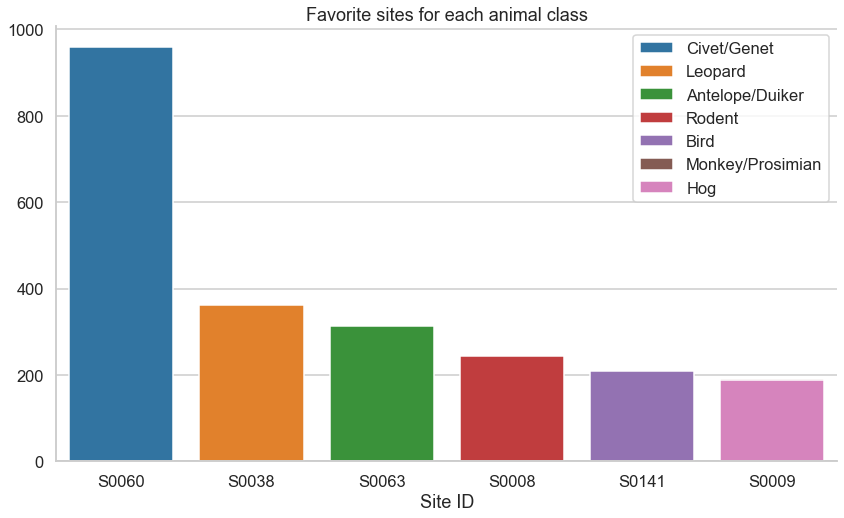

In [121]:
plt.figure(figsize=(14, 8))
sns.barplot(data=popular_sites, x='site', y='count', hue='animal_class', dodge=False)
plt.title('Favorite sites for each animal class')
#plt.xticks(rotation=180)

plt.ylabel('')
plt.xlabel('Site ID')
plt.legend(loc='upper right')
sns.despine(right=True);
#plt.savefig('bar_animal_count', bbox_inches='tight')

#### Top five favorite sites for each animal class

In [158]:
sns.set_context('notebook', font_scale=1.2)

In [159]:
bird_sites = grouped[grouped['label']== 'bird'].sort_values(by='count', ascending=False).iloc[0:5,:]
bird_sites

,site,label,count
469,S0141,bird,210
33,S0009,bird,155
393,S0120,bird,129
27,S0008,bird,124
270,S0074,bird,74


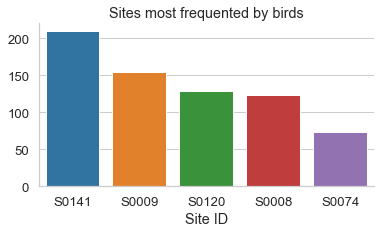

In [167]:
plt.figure(figsize=(6, 3))
sns.barplot(data=bird_sites, x='site', y='count')
plt.title('Sites most frequented by birds')
#plt.xticks(rotation=180)

plt.ylabel('')
plt.xlabel('Site ID')
sns.despine(right=True);
plt.savefig('Sites most frequented by birds', bbox_inches='tight')

In [98]:
leopard_sites = grouped[grouped['label']== 'leopard'].sort_values(by='count', ascending=False).iloc[0:5,:]

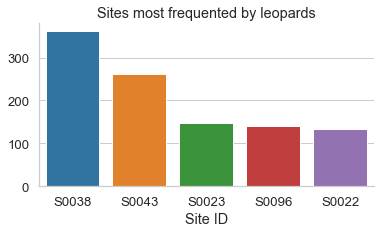

In [166]:
plt.figure(figsize=(6, 3))
sns.barplot(data=leopard_sites, x='site', y='count')
plt.title('Sites most frequented by leopards')
#plt.xticks(rotation=180)

plt.ylabel('')
plt.xlabel('Site ID')
sns.despine(right=True);
plt.savefig('Sites most frequented by leopards', bbox_inches='tight')

In [102]:
monkey_sites = grouped[grouped['label']== 'monkey_prosimian'].sort_values(by='count', ascending=False).iloc[0:5,:]

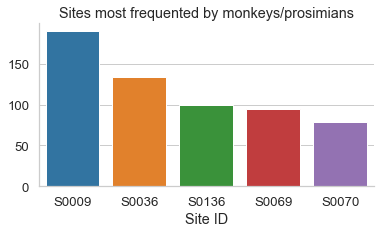

In [161]:
plt.figure(figsize=(6, 3))
sns.barplot(data=monkey_sites, x='site', y='count')
plt.title('Sites most frequented by monkeys/prosimians')
#plt.xticks(rotation=180)

plt.ylabel('')
plt.xlabel('Site ID')
sns.despine(right=True);
plt.savefig('Sites most frequented by monkeys-prosimians', bbox_inches='tight')

In [104]:
rodent_sites = grouped[grouped['label']== 'rodent'].sort_values(by='count', ascending=False).iloc[0:5,:]

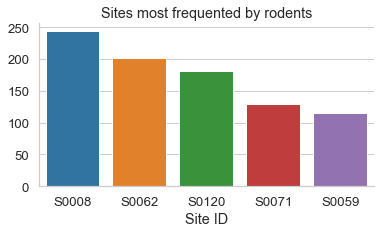

In [162]:
plt.figure(figsize=(6, 3))
sns.barplot(data=rodent_sites, x='site', y='count')
plt.title('Sites most frequented by rodents')
#plt.xticks(rotation=180)

plt.ylabel('')
plt.xlabel('Site ID')
sns.despine(right=True);
plt.savefig('Sites most frequented by rodents', bbox_inches='tight')

In [130]:
antelope_duiker_sites = grouped[grouped['label']== 'antelope_duiker'].sort_values(by='count', ascending=False).iloc[0:5,:]

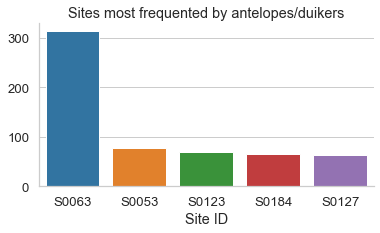

In [163]:
plt.figure(figsize=(6, 3))
sns.barplot(data=antelope_duiker_sites, x='site', y='count')
plt.title('Sites most frequented by antelopes/duikers')
#plt.xticks(rotation=180)

plt.ylabel('')
plt.xlabel('Site ID')
sns.despine(right=True);
plt.savefig('Sites most frequented by antelopes-duikers', bbox_inches='tight')

In [125]:
civet_genet_sites = grouped[grouped['label']== 'civet_genet'].sort_values(by='count', ascending=False).iloc[0:5,:]

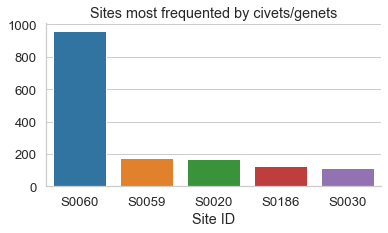

In [164]:
plt.figure(figsize=(6, 3))
sns.barplot(data=civet_genet_sites, x='site', y='count')
plt.title('Sites most frequented by civets/genets')
#plt.xticks(rotation=180)

plt.ylabel('')
plt.xlabel('Site ID')
sns.despine(right=True);
plt.savefig('Sites most frequented by civets-genets', bbox_inches='tight')

In [132]:
hog_sites = grouped[grouped['label']== 'hog'].sort_values(by='count', ascending=False).iloc[0:5,:]

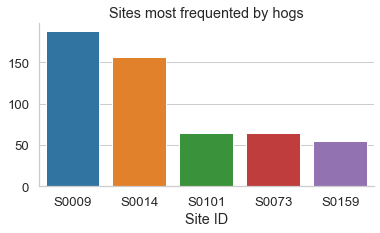

In [165]:
plt.figure(figsize=(6, 3))
sns.barplot(data=hog_sites, x='site', y='count')
plt.title('Sites most frequented by hogs')
#plt.xticks(rotation=180)

plt.ylabel('')
plt.xlabel('Site ID')
sns.despine(right=True);
plt.savefig('Sites most frequented by hogs', bbox_inches='tight')

### Validation Data

For the validation data, we will take about 10% of the training data. We will also split the data such that sites on the training data will be different from sites on the validation data, to avoid teacing the model to identify sites as opposed to animals. 

After extensive EDA on the site data above, we have selected the sites below for the validation data because (1) it makes up about 10% of the training data, (2) has observations of all animal classes.

In [47]:
val_data = grouped[(grouped['site']=='S0009')\
                 | (grouped['site']=='S0043')| (grouped['site']=='S0059')\
                 |(grouped['site']== 'S0026')]

In [48]:
val_sites_list = ['S0009', 'S0043', 'S0059', 'S0026']

In [49]:
val_data['count'].sum()

1650

In [50]:
val_data.head(2)

,site,label,count
32,S0009,antelope_duiker,33
33,S0009,bird,155


In [51]:
val_data['label'].value_counts()

blank               4
monkey_prosimian    4
rodent              4
antelope_duiker     3
bird                3
civet_genet         3
leopard             2
hog                 1
Name: label, dtype: int64

In [115]:
val_data_count = val_data.groupby('label').sum().sort_values(by='count', ascending=False)['count']
val_data_count

label
monkey_prosimian    310
leopard             278
rodent              242
bird                235
civet_genet         202
hog                 188
antelope_duiker     107
blank                88
Name: count, dtype: int64

In [116]:
locations = [1, 2, 3, 4, 5, 6, 7, 8]
labels = [label.replace('_', '/').title() for label in val_data_count.index]

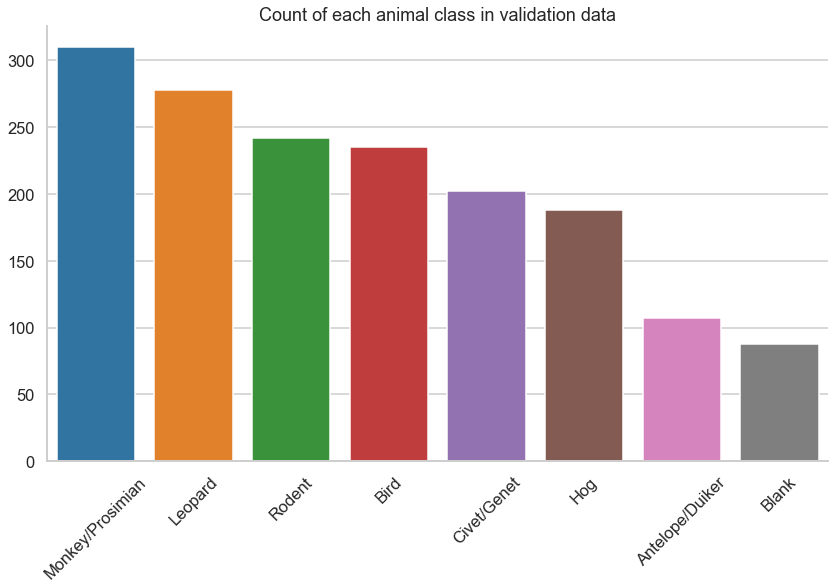

In [117]:
plt.figure(figsize=(14, 8))
sns.barplot(y=val_data_count, x=labels)
plt.title('Count of each animal class in validation data')
plt.xticks(rotation=45)
plt.ylabel('');
sns.despine(right=True)
plt.savefig('val_data_count', bbox_inches='tight')

In [55]:
pwd

'/Users/luisagonzalez/Library/CloudStorage/OneDrive-Personal/Documents/General_Assembly/Projects/Wildlife_Image_Classification'

In [56]:
directory = './data/train_features/'

In [57]:
files_labels['file_name'] = files_labels['filepath'].str[-12:]

In [58]:
files_labels.head(2)

,id,filepath,site,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,label,file_name
0,ZJ000000,train_features/ZJ000000.jpg,S0120,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,bird,ZJ000000.jpg
1,ZJ000001,train_features/ZJ000001.jpg,S0069,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,monkey_prosimian,ZJ000001.jpg


In [59]:
train_df = files_labels.loc[files_labels['site'].isin(val_sites_list)==False]

In [60]:
train_df['label'].value_counts()

antelope_duiker     2367
civet_genet         2221
monkey_prosimian    2182
blank               2125
leopard             1976
rodent              1771
bird                1406
hog                  790
Name: label, dtype: int64

In [61]:
val_df = files_labels.loc[files_labels['site'].isin(val_sites_list)]

In [62]:
val_df['site'].value_counts()

S0009    664
S0043    444
S0059    438
S0026    104
Name: site, dtype: int64

In [63]:
val_df['label'].value_counts()

monkey_prosimian    310
leopard             278
rodent              242
bird                235
civet_genet         202
hog                 188
antelope_duiker     107
blank                88
Name: label, dtype: int64

#### Images

In [171]:
datagen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2, 1.2],

)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df, 
    directory=directory, 
    x_col="file_name", 
    y_col="label", 
    class_mode="categorical", 
    target_size=(256,256), 
    batch_size=32
)

Found 14838 validated image filenames belonging to 8 classes.


In [168]:
datagen1=ImageDataGenerator(
    rescale=1./255
)
val_generator=datagen1.flow_from_dataframe(
    dataframe=val_df, 
    directory=directory, 
    x_col="file_name", 
    y_col="label", 
    class_mode="categorical", 
    target_size=(256,256), 
    batch_size=32
)

Found 1650 validated image filenames belonging to 8 classes.


(32, 256, 256, 3)


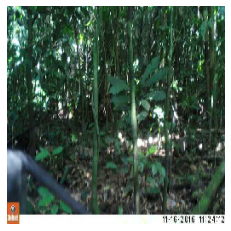

(32, 256, 256, 3)


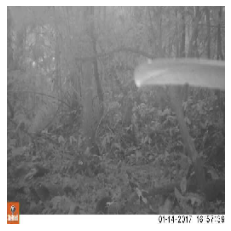

(32, 256, 256, 3)


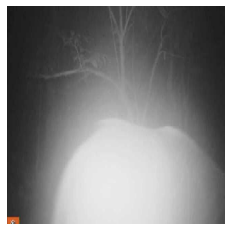

(32, 256, 256, 3)


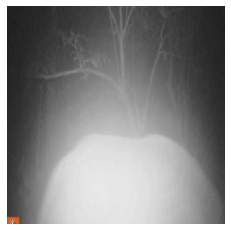

(32, 256, 256, 3)


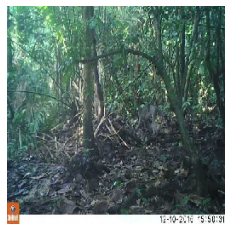

In [170]:
for _ in range(5):
    img, label = val_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.axis('off')
    plt.show();